In [1]:
# !pip install missingno

In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import quilt
import warnings
import re
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [3]:
from matplotlib import font_manager, rc # rc == run configure(configuration file)

%matplotlib inline
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) 


## 1.  Preparing dataset & Feature engineering, Feature selection

- 기상자료개방포털에서 데이터를 가져올때부터 열을 선택할 수 있었기에, 필요할것 같은 열만 선택해서 빼왔습니다.
- https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36

In [4]:
df_2014x = pd.read_csv('기상데이터 2014부터.csv', encoding='cp949')

df_y = pd.read_excel('2014년도 부터 업종별, 제조업없음.xlsx')
df_y = df_y.transpose()
df_y = df_y.drop(columns=0)
df_y = df_y.rename(columns={1:'소매업', 2:'음식점업', 3:'스포츠 및 오락관련 서비스업', 4:'개인 서비스업'})
df_y = df_y.drop(index='업종별(1)')
df_y = df_y.reset_index()

df_2014x

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),평균 이슬점온도(°C),평균 상대습도(%),일 최심적설(cm),평균 지면온도(°C)
0,156,광주,2014-01-01,5.2,0.9,10.6,NaN,4.7,1.9,-4.1,54.5,NaN,2.8
1,156,광주,2014-01-02,4.3,-0.5,10.3,NaN,3.4,1.1,-6.2,51.1,NaN,2.8
2,156,광주,2014-01-03,4.5,-0.9,11.8,NaN,2.4,0.9,-6.6,47.3,NaN,2.6
3,156,광주,2014-01-04,2.4,-0.9,6.7,NaN,3.2,1.4,-6.2,55.4,NaN,2.7
4,156,광주,2014-01-05,1.2,-3.5,7.6,NaN,2.8,1.2,-8.1,54.4,NaN,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521,156,광주,2020-11-26,9.1,6.4,13.8,0.0,3.5,1.3,0.7,57.1,NaN,9.2
2522,156,광주,2020-11-27,7.7,5.7,10.7,NaN,3.1,1.2,-0.1,58.6,NaN,7.6
2523,156,광주,2020-11-28,5.1,3.6,7.0,NaN,3.8,1.9,-4.7,49.9,NaN,7.6
2524,156,광주,2020-11-29,4.5,2.7,7.1,NaN,2.7,1.3,-2.4,61.0,NaN,5.9


- 각 업종의 BSI 지수가 날씨와 관계가 있어보이는 듯하여, 월 평균 기온과 그래프를 그려보았습니다.

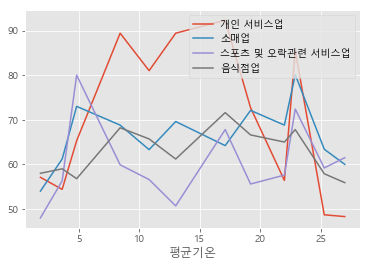

In [5]:
df = pd.read_csv('2019기상데이터.csv', encoding='cp949')

df_tmp = df['평균기온(°C)'].copy()
df_tmp = pd.DataFrame(df_tmp)
df_tmp = df_tmp.rename(columns={'평균기온(°C)': '평균기온'})

df_bsi = df_y.loc[:,['소매업', '음식점업', '스포츠 및 오락관련 서비스업','개인 서비스업']]
df_bsi = df_bsi[60:72]
df_bsi = df_bsi.reset_index()
del df_bsi['index']
df_bsitmp = df_bsi.join(df_tmp)

df_bsitmp
df_pvtmp = pd.pivot_table(df_bsitmp, index='평균기온', aggfunc='first')

df_pvtmp.plot()

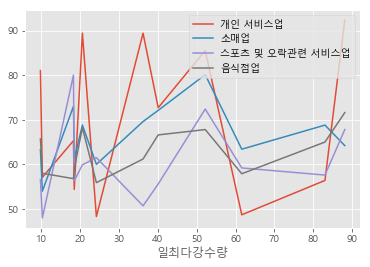

In [6]:
df_humidity = df['일최다강수량(mm)'].copy()
df_humidity = pd.DataFrame(df_humidity)
df_humidity = df_humidity.rename(columns={'일최다강수량(mm)': '일최다강수량'})

df_bsihumid = df_bsi.join(df_humidity)
df_pvhumidity = pd.pivot_table(df_bsihumid, index='일최다강수량', aggfunc='first')

df_pvhumidity.plot()

- 비올때 파전에 막걸리 먹으러 간다고 하는것처럼, 날씨요소가 BSI지수에 영향을 줄것이라 생각하여 이번 프로젝트를 진행하게되었습니다.

- NaN데이터 분포를 보고자 msno.matrix를 썼습니다.

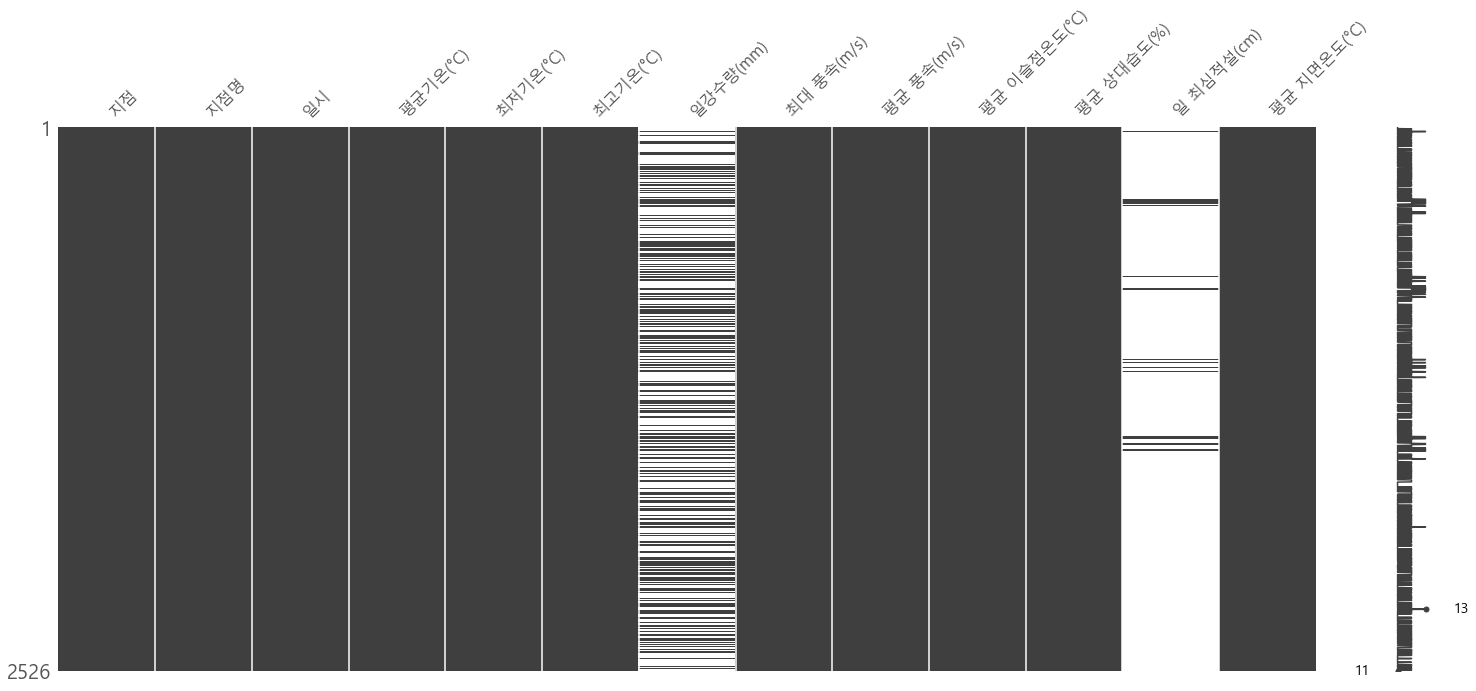

In [7]:
msno.matrix(df_2014x)

- NaN데이터가 일강수량, 일 최심적설 열에만 존재함을 볼 수 있었습니다.

In [8]:
df_2014x.columns

Index(['지점', '지점명', '일시', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)',
       '최대 풍속(m/s)', '평균 풍속(m/s)', '평균 이슬점온도(°C)', '평균 상대습도(%)', '일 최심적설(cm)',
       '평균 지면온도(°C)'],
      dtype='object')

- 필요없는 열을 날려주었으며,
- 강수량과 적설량같은 경우는 눈,비가 내리지 않았으면 NaN데이터로 올려져있을거라 추측하고 0으로 채웠습니다.
- 그리고 이후 y데이터 처리에 쓰기위해 일시 부분을 따로 뽑아서 처리해 놓았고,
- °C 이 부분때문에 뒤에서 오류가 나, 섭씨로 바꿔주었습니다.

In [9]:
def date_to_month(df):
    del df['지점']
    del df['지점명']

    df['일강수량(mm)'].fillna(0, inplace = True)
    df['일 최심적설(cm)'].fillna(0, inplace = True)
    
    date_list = list(df['일시'])
    new_date = []

    for date in date_list:
        month = (int(date[5:7])) / 100
        year = int(date[:4])
        new_date.append(year+month)
    # ex) 2014-01-04 ---> year = 2014, month = 0.01, new_data.append(2014 + 0.01)
    
    df_date = pd.DataFrame(new_date)
    df = df.join(df_date)
    df.rename(columns = {0 : '날짜'}, inplace=True)
    df.rename(columns={'평균기온(°C)' : '평균기온(섭씨)', '최저기온(°C)' :'최저기온(섭씨)',
                         '최고기온(°C)' : '최고기온(섭씨)', '평균 이슬점온도(°C)':'평균이슬점온도(섭씨)'
                       , '평균 지면온도(°C)': '평균지면온도(섭씨)'}, inplace=True)
    del df['일시']
    
    return df

- min-max 방식으로 열들을 스케일링 하여 0 ~ 1 사이로 맞춰주었습니다.
- 습도열 같은 경우는 /100을 하여 %로 바꾸기 이전으로 바꿔주었습니다.

In [10]:
def reRange(x, oldMin, oldMax, newMin, newMax):
    return (x - oldMin)*(newMax - newMin) / (oldMax - oldMin) + newMin

def mean_max(df):
    df['평균기온(scaled)'] = reRange(df['평균기온(섭씨)'], min(df['평균기온(섭씨)']), max(df['평균기온(섭씨)']), 0, 1)
    del df['평균기온(섭씨)']
    df['최고기온(scaled)'] = reRange(df['최고기온(섭씨)'], min(df['최고기온(섭씨)']), max(df['최고기온(섭씨)']), 0, 1)
    del df['최고기온(섭씨)']
    df['최저기온(scaled)'] = reRange(df['최저기온(섭씨)'], min(df['최저기온(섭씨)']), max(df['최저기온(섭씨)']), 0, 1)
    del df['최저기온(섭씨)']
    df['평균 상대습도(scaled)'] = reRange(df['평균 상대습도(%)'], min(df['평균 상대습도(%)']), max(df['평균 상대습도(%)']), 0, 1)
    del df['평균 상대습도(%)']
    df['평균이슬점온도(scaled)'] = reRange(df['평균이슬점온도(섭씨)'], min(df['평균이슬점온도(섭씨)']), max(df['평균이슬점온도(섭씨)']), 0, 1)
    del df['평균이슬점온도(섭씨)']
    df['일강수량(scaled)'] = reRange(df['일강수량(mm)'], min(df['일강수량(mm)']), max(df['일강수량(mm)']), 0, 1)
    del df['일강수량(mm)']
    df['최대풍속(scaled)'] = reRange(df['최대 풍속(m/s)'], min(df['최대 풍속(m/s)']), max(df['최대 풍속(m/s)']), 0, 1)
    del df['최대 풍속(m/s)']
    df['평균풍속(scaled)'] = reRange(df['평균 풍속(m/s)'], min(df['평균 풍속(m/s)']), max(df['평균 풍속(m/s)']), 0, 1)
    del df['평균 풍속(m/s)']
    df['평균지면온도(scaled)'] = reRange(df['평균지면온도(섭씨)'], min(df['평균지면온도(섭씨)']), max(df['평균지면온도(섭씨)']), 0, 1)
    del df['평균지면온도(섭씨)']
    
    return df
    

- 불러다 쓰기 쉽게 위 전처리 과정을 묶어 함수로 만들어 두었습니다.

In [11]:
def feature_eng (df):
    df = date_to_month(df)
    df = mean_max(df)

    return df

In [12]:
df_2014x = feature_eng(df_2014x)

df_2014x

,일 최심적설(cm),날짜,평균기온(scaled),최고기온(scaled),최저기온(scaled),평균 상대습도(scaled),평균이슬점온도(scaled),일강수량(scaled),최대풍속(scaled),평균풍속(scaled),평균지면온도(scaled)
0,0.0,2014.01,0.354217,0.396104,0.317380,0.407457,0.306167,0.0,0.301724,0.258065,0.174840
1,0.0,2014.01,0.332530,0.389610,0.282116,0.362184,0.259912,0.0,0.189655,0.129032,0.174840
2,0.0,2014.01,0.337349,0.422078,0.272040,0.311585,0.251101,0.0,0.103448,0.096774,0.170576
3,0.0,2014.01,0.286747,0.311688,0.272040,0.419441,0.259912,0.0,0.172414,0.177419,0.172708
4,0.0,2014.01,0.257831,0.331169,0.206549,0.406125,0.218062,0.0,0.137931,0.145161,0.153518
...,...,...,...,...,...,...,...,...,...,...,...
2521,0.0,2020.11,0.448193,0.465368,0.455919,0.442077,0.411894,0.0,0.198276,0.161290,0.311301
2522,0.0,2020.11,0.414458,0.398268,0.438287,0.462051,0.394273,0.0,0.163793,0.145161,0.277186
2523,0.0,2020.11,0.351807,0.318182,0.385390,0.346205,0.292952,0.0,0.224138,0.258065,0.277186
2524,0.0,2020.11,0.337349,0.320346,0.362720,0.494008,0.343612,0.0,0.129310,0.161290,0.240938


- y데이터에서도 다음에 할 데이터를 늘리는 작업에 쓰기 위해 일시를 빼두었습니다.

In [13]:

date_list = list(df_y['index'])
new_date = []

for date in date_list:
    month = (int(date[6:8])) / 100
    year = int(date[:4])
    new_date.append(year+month)
# y 데이터의 날짜열은 년도와 월수 사이에 공백이 있어 [6:8]로 꺼내는 범위만 바뀌었습니다.
    
df_date = pd.DataFrame(new_date)
df_y = df_y.join(df_date)
df_y.rename(columns = {0 : '날짜'}, inplace=True)
del df_y['index']

df_y


,소매업,음식점업,스포츠 및 오락관련 서비스업,개인 서비스업,날짜
0,95.9,82.6,87.8,100.5,2014.01
1,80,86.5,79.3,91.9,2014.02
2,102.7,101.5,85.9,113,2014.03
3,41.9,38.9,28,64.7,2014.04
4,71.6,64.8,70.3,51.9,2014.05
...,...,...,...,...,...
78,65.5,68.4,65,54.7,2020.07
79,63.6,68.9,69,61.2,2020.08
80,60.3,44.7,30.7,56.2,2020.09
81,69.8,78,73.4,88.9,2020.10


- y데이터는 아쉽게도 일별로 상세히 나와있지 않고, 월별로만 공개되어있어서 각 년도, 월에 해당하는 데이터를 복제하여 데이터를 충분히 늘려주었습니다.

- x데이터와 y데이터에서 뽑아놓은 날짜 데이터를 기준으로 같은 값만큼 늘려 새로운 y데이터를 만들어주는 함수를 만들었습니다.

- https://www.mss.go.kr/site/smba/foffice/ex/statDB/temaList.do

In [14]:
def y_expand(ycolumn1):
    list_xdate = list(df_2014x['날짜'])
    list_ydate = list(df_y['날짜'])

    i = 0
    new_y1 = []
    for ydate in list_ydate:
        for xdate in list_xdate:
            if xdate == ydate: # int로 준비해둔 '날짜'가 같으면 새로운 list에 추가해주는 방법
                new_y1.append(ycolumn1[i])
        i+=1
    df_newy1 = pd.DataFrame(new_y1)
    return df_newy1


- 위의 함수를 이용해 y를 늘려준 뒤, 이후에 쓰기 편하도록 모든 데이터를 하나의 데이터프레임으로 만들어놓았습니다.

In [15]:
y_column1 = list(df_y['소매업'])
y_column2 = list(df_y['음식점업'])
y_column3 = list(df_y['스포츠 및 오락관련 서비스업'])
y_column4 = list(df_y['개인 서비스업'])

df_newy1 = y_expand(y_column1)
df_newy1 = df_newy1.rename(columns={0:'소매업'})
df_newy2 = y_expand(y_column2)
df_newy2 = df_newy2.rename(columns={0:'음식점업'})
df_newy3 = y_expand(y_column3)
df_newy3 = df_newy3.rename(columns={0:'스포츠 및 오락관련 서비스업'})
df_newy4 = y_expand(y_column4)
df_newy4 = df_newy4.rename(columns={0:'개인 서비스업'})

df_newy = df_newy1.join(df_newy2)
df_newy = df_newy.join(df_newy3)
df_newy = df_newy.join(df_newy4)

all_data = df_2014x.join(df_newy)

all_data[:2191] # 2014년 1월 1일 ~ 2019년 12월 31일 까지의 all data

,일 최심적설(cm),날짜,평균기온(scaled),최고기온(scaled),최저기온(scaled),평균 상대습도(scaled),평균이슬점온도(scaled),일강수량(scaled),최대풍속(scaled),평균풍속(scaled),평균지면온도(scaled),소매업,음식점업,스포츠 및 오락관련 서비스업,개인 서비스업
0,0.0,2014.01,0.354217,0.396104,0.317380,0.407457,0.306167,0.000000,0.301724,0.258065,0.174840,95.9,82.6,87.8,100.5
1,0.0,2014.01,0.332530,0.389610,0.282116,0.362184,0.259912,0.000000,0.189655,0.129032,0.174840,95.9,82.6,87.8,100.5
2,0.0,2014.01,0.337349,0.422078,0.272040,0.311585,0.251101,0.000000,0.103448,0.096774,0.170576,95.9,82.6,87.8,100.5
3,0.0,2014.01,0.286747,0.311688,0.272040,0.419441,0.259912,0.000000,0.172414,0.177419,0.172708,95.9,82.6,87.8,100.5
4,0.0,2014.01,0.257831,0.331169,0.206549,0.406125,0.218062,0.000000,0.137931,0.145161,0.153518,95.9,82.6,87.8,100.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,0.0,2019.12,0.301205,0.313853,0.307305,0.388815,0.270925,0.000000,0.275862,0.274194,0.172708,73.0,56.8,80.0,65.3
2187,0.0,2019.12,0.310843,0.374459,0.264484,0.328895,0.246696,0.000000,0.077586,0.080645,0.170576,73.0,56.8,80.0,65.3
2188,0.0,2019.12,0.330120,0.296537,0.319899,0.731025,0.407489,0.037765,0.241379,0.129032,0.185501,73.0,56.8,80.0,65.3
2189,0.0,2019.12,0.385542,0.406926,0.337531,0.785619,0.475771,0.001156,0.318966,0.145161,0.257996,73.0,56.8,80.0,65.3


## 2. Split to train, test

- y데이터만 해도 4종류이고 이후에 다른 case도 편하게 진행하기 위해 train_test_split도 함수로 만들어 놨습니다.
- x데이터는 random_state가 각각 다른것이 아니기에 어차피 모두 같을것이라  x_train, x_test 두개만 빼냈습니다.

In [16]:
def selecty(x_data, y_data):
    x_train, x_test, y_train1, y_test1 = model_selection.train_test_split(x_data,
                                                                          y_data['소매업'],
                                                                          test_size=0.3,
                                                                          random_state=0)
    x_train, x_test, y_train2, y_test2 = model_selection.train_test_split(x_data,
                                                                          y_data['음식점업'],
                                                                          test_size=0.3,
                                                                          random_state=0)
    x_train, x_test, y_train3, y_test3 = model_selection.train_test_split(x_data,
                                                                          y_data['스포츠 및 오락관련 서비스업'],
                                                                          test_size=0.3,
                                                                          random_state=0)
    x_train, x_test, y_train4, y_test4 = model_selection.train_test_split(x_data,
                                                                          y_data['개인 서비스업'],
                                                                          test_size=0.3,
                                                                          random_state=0)
    return x_train, x_test ,y_train1, y_test1, y_train2, y_test2,y_train3, y_test3, y_train4, y_test4

- 시계열 처리를 하지 않았기에, 날짜 열을 삭제하고, model에 쓸 데이터들을 만들었습니다.

In [17]:
from sklearn import model_selection, linear_model
from sklearn.metrics import mean_squared_error
x_data = df_2014x.copy()
del x_data['날짜']

x_train, x_test,y_train1, y_test1, y_train2, y_test2,y_train3, y_test3, y_train4, y_test4 = selecty(x_data, df_newy)

## 3. LinearRegression

- 여러번에 걸쳐 model을 사용하기에, 시각화까지 한번에 묶어 함수로 만들었습니다.

In [18]:

def lrmodel(x_train, y_train, x_test, y_test, case_num=1, mods=0):

    model_LR1 = linear_model.LinearRegression()
    model_LR1.fit(x_train, y_train)
    
    if case_num == 1:
        data_categ = '소매업' 
    elif case_num == 2:
        data_categ = '음식점업' 
    elif case_num == 3:
        data_categ = '스포츠 및 오락관련 서비스업' 
    elif case_num == 4:
        data_categ = '개인 서비스업' 
    else:
        data_categ = 'not defined'
    # 시각화에 용이하게 하기위해 parameter 하나를 더 넣었습니다.

    pred = model_LR1.predict(x_test)
    print('MSE(Training data {}) : '.format(data_categ), mean_squared_error(pred, y_test))
    if mods == 0:
        pred = pd.DataFrame(pred)
        short_pred = pred[:20] # 데이터 수가 너무 많아 모델의 성능 시각화를 위해 20개만 빼냈습니다.
        df_ytest = pd.DataFrame(y_test)
        short_y = df_ytest[:20]
        short_y = short_y.reset_index()
        del short_y['index']
        
        mse = mean_squared_error(pred, y_test) # 모델간 비교를 위해 return값으로 이것도 받는다.
        result = short_pred.join(short_y)
        result = result.rename(columns={0:'예측값'})
    
    elif mods == 1:
        pred = pd.DataFrame(pred)
        short_pred = pred[:11]
        short_pred = short_pred.rename(columns={0:'예측값'})
        df_ytest = pd.DataFrame(y_test)
        short_y = df_ytest
        short_y = short_y.reset_index()
        del short_y['index']
        
        mse = mean_squared_error(pred, y_test) # 모델간 비교를 위해 return값으로 이것도 받는다.
        result = short_pred.join(short_y)
        if case_num == 1:
            result = result.rename(columns={0:'소매업'})
        elif case_num == 2:
            result = result.rename(columns={0:'음식점업'})
        
    result.plot()
    
    return result, mse

MSE(Training data 소매업) :  153.11570394073905
MSE(Training data 음식점업) :  135.24247305513015
MSE(Training data 스포츠 및 오락관련 서비스업) :  169.24322812831647
MSE(Training data 개인 서비스업) :  307.39137200389644


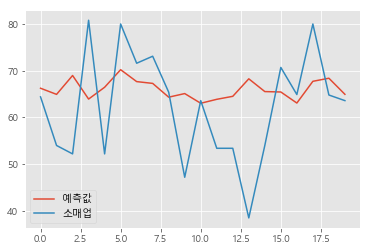

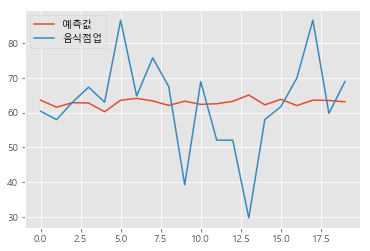

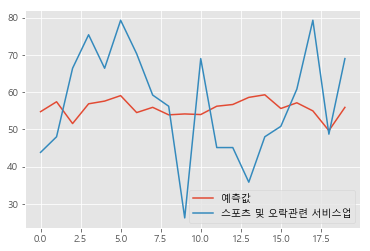

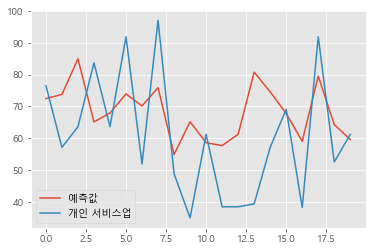

In [19]:
result, mse1 = lrmodel(x_train, y_train1, x_test, y_test1, case_num=1)
result, mse2 = lrmodel(x_train, y_train2, x_test, y_test2, case_num=2)
result, mse3 = lrmodel(x_train, y_train3, x_test, y_test3, case_num=3)
result, mse4 = lrmodel(x_train, y_train4, x_test, y_test4, case_num=4)

first_mse = [mse1, mse2, mse3, mse4] # 나중에 모델간 비교를 위해 빼서 DataFrame으로 만들어둔 것
df_fmse = pd.DataFrame(first_mse)
df_fmse = df_fmse.rename(columns={0:'2020년도 포함'},
                        index={0:'소매업',1:'음식점업', 2:'스포츠 및 오락관련 서비스업', 3:'개인 서비스업'})

In [20]:
result.head()

,예측값,개인 서비스업
0,72.460043,76.5
1,73.754405,57.1
2,84.941692,63.6
3,65.100633,83.7
4,67.913309,63.6


- 2020년도는 날씨 외에 훨씬 큰 영향을 끼친 요인이 따로 있었기에, 2020년도를 제외해버리고 model을 학습시켜보기로 했습니다.
- 아까 미리 뽑아둔 all_data[:2191]를 이용하여 2020년이 제외된 x,y데이터를 꺼냅니다.

In [21]:
def sel_feat(df_data):

    dfx = df_data.loc[:, ['일 최심적설(cm)', '평균기온(scaled)', '최고기온(scaled)', '최저기온(scaled)',
                                    '평균 상대습도(scaled)', '평균이슬점온도(scaled)', '일강수량(scaled)', '최대풍속(scaled)',
                                    '평균풍속(scaled)', '평균지면온도(scaled)']]

    dfy = df_data.loc[:, ['소매업', '음식점업', '스포츠 및 오락관련 서비스업','개인 서비스업']]
    
    return dfx, dfy

In [22]:
df_del2020 = all_data[:2191].copy()

df_del2020x, df_del2020y = sel_feat(df_del2020)

In [23]:
df_del2020y

,소매업,음식점업,스포츠 및 오락관련 서비스업,개인 서비스업
0,95.9,82.6,87.8,100.5
1,95.9,82.6,87.8,100.5
2,95.9,82.6,87.8,100.5
3,95.9,82.6,87.8,100.5
4,95.9,82.6,87.8,100.5
...,...,...,...,...
2186,73.0,56.8,80.0,65.3
2187,73.0,56.8,80.0,65.3
2188,73.0,56.8,80.0,65.3
2189,73.0,56.8,80.0,65.3


In [24]:
x_train, x_test,y_train1, y_test1, y_train2, y_test2,y_train3, y_test3, y_train4, y_test4 = selecty(df_del2020x, df_del2020y)

MSE(Training data 소매업) :  142.53128722022367
MSE(Training data 음식점업) :  96.92420849377157
MSE(Training data 스포츠 및 오락관련 서비스업) :  146.82348132815127
MSE(Training data 개인 서비스업) :  285.65221206222077


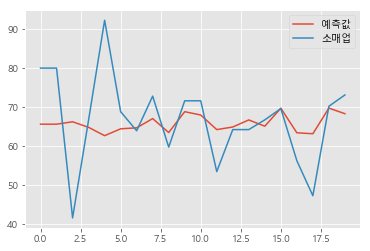

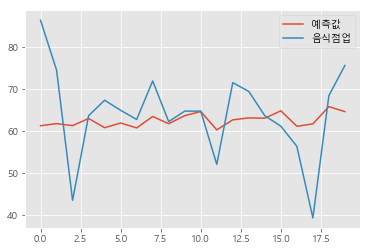

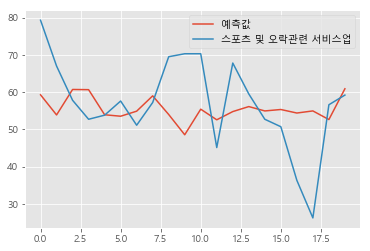

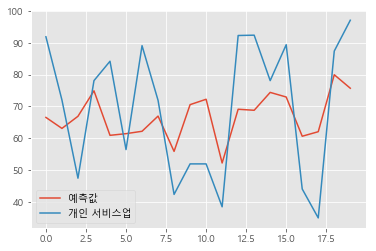

In [25]:
result, mse5 = lrmodel(x_train, y_train1, x_test, y_test1, case_num=1)
result, mse6 = lrmodel(x_train, y_train2, x_test, y_test2, case_num=2)
result, mse7 = lrmodel(x_train, y_train3, x_test, y_test3, case_num=3)
result, mse8 = lrmodel(x_train, y_train4, x_test, y_test4, case_num=4)

second_mse = [ mse5, mse6, mse7, mse8]
df_smse = pd.DataFrame(second_mse)
df_smse = df_smse.rename(columns={0:'2020년도 제외'}
                         ,index={0:'소매업',1:'음식점업', 2:'스포츠 및 오락관련 서비스업', 3:'개인 서비스업'})

- 크게 차이가 나진 않지만, 그래도 2020년도 데이터를 없앤것이 model의 성능이 더 높았습니다.

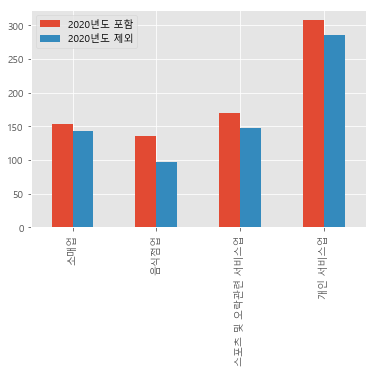

In [26]:
mse_comp = df_fmse.join(df_smse)

mse_comp.plot(kind='bar')

- 2014 ~ 2018년도 데이터로 학습시키고 2019년도와 2020년도 데이터를 각각의 테스트 데이터로 주어 얼마나 차이가 나나 실험해보았습니다.

- 이때 y데이터는 가장 큰 차이가 난 음식점업과, 가장 작은 차이가 난 소매업 두개를 선정했습니다.

In [27]:
data2018 = all_data[:1826].copy()
data2019 = all_data[1826:2191].copy()
data2020 = all_data[2191:].copy()

x_data2018, y_data2018 = sel_feat(data2018)
x_data2019, y_data2019 = sel_feat(data2019)
x_data2020, y_data2020 = sel_feat(data2020)

trainx = np.array(x_data2018)
trainy1 = np.array(y_data2018['소매업'])
trainy2 = np.array(y_data2018['음식점업'])

testx1 = np.array(x_data2019)
testy1 = np.array(y_data2019['소매업'])
testy2 = np.array(y_data2019['음식점업'])

testx2 = np.array(x_data2020)
testy3 = np.array(y_data2020['소매업'])
testy4 = np.array(y_data2020['음식점업'])


MSE(Training data 소매업) :  55.820098968394646
MSE(Training data 음식점업) :  26.072171235105284


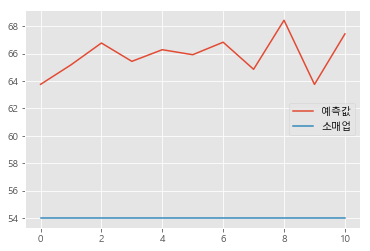

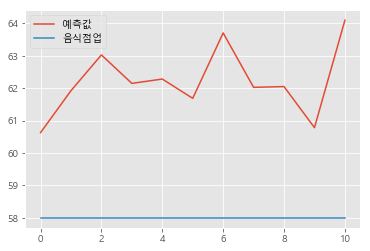

In [28]:
result, mse2019 = lrmodel(trainx, trainy1, testx1, testy1, case_num=1, mods=1)
result, mse20192 = lrmodel(trainx, trainy2, testx1, testy2, case_num=2, mods=1)

mse19_list = [mse2019, mse20192]
df_mse19 = pd.DataFrame(mse19_list)
df_mse19 = df_mse19.rename(columns={0:'19년도 mse'})

MSE(Training data 소매업) :  288.42837747931463
MSE(Training data 음식점업) :  486.7383459079371


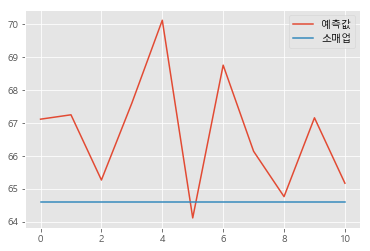

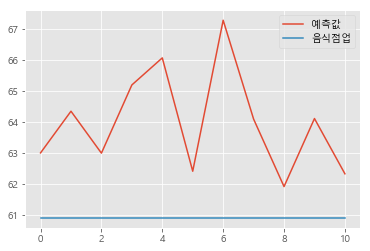

In [29]:
result, mse2020 = lrmodel(trainx, trainy1, testx2, testy3, case_num=1, mods=1)
result, mse20202 = lrmodel(trainx, trainy2, testx2, testy4, case_num=2, mods=1)

mse20_list = [mse2020, mse20202]
df_mse20 = pd.DataFrame(mse20_list)
df_mse20 = df_mse20.rename(columns={0:'20년도 mse'})

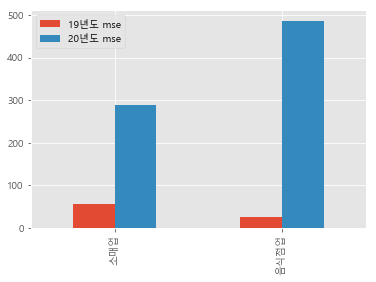

In [49]:
df_1920 = df_mse19.join(df_mse20)
df_1920 = df_1920.rename(index={0:'소매업', 1:'음식점업'})
df_1920.plot(kind='bar')

- 20년도를 예측했을때 눈에 띄게 mse가 증가했음을 볼 수 있었습니다.

## 4. Regression with Keras

In [31]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [32]:
import os
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

- 이번에도 역시 시각화까지 함수화 했습니다.

In [33]:
def kerasRegression(x_train, y_train1, x_test, y_test1):
    model = models.Sequential()

    model.add(layers.Dense(input_dim=10, units=32, activation=None, kernel_initializer=initializers.he_uniform()))
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(rate=0.3))
    
    model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(rate=0.3)) # 오버피팅을 막기 위해 두 hidden layer에 Dropout을 0.3 비율로 주었습니다.

    model.add(layers.Dense(units=1, activation=None)) 

    model.compile(optimizer=optimizers.Adam(),
                  loss=losses.mean_squared_error,
                  metrics=[metrics.mean_squared_error])

    history = model.fit(x_train, y_train1, batch_size=100, epochs=1000, validation_split=0.3, verbose=0)

    result = model.evaluate(x_test, y_test1)

    print('loss (mean_squared_error) :', result[0])

    loss = history.history['mean_squared_error']
    val_loss = history.history['val_mean_squared_error']

    x_len = np.arange(len(loss))

    plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
    plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('Loss(MSE)')
    plt.show()

    loss = history.history['mean_squared_error']
    val_loss = history.history['val_mean_squared_error']

    x_len = np.arange(len(loss))

    plt.plot(x_len[200:], loss[200:], marker='.', c='blue', label="Train-set loss.")
    plt.plot(x_len[200:], val_loss[200:], marker='.', c='red', label="Validation-set loss.")

    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('Loss(MSE)')
    plt.show()
    
    md_pred = pd.DataFrame(model.predict(x_test))
    md_pred = md_pred.rename(columns={0:'예측값'})
    md_pred = md_pred[:20] # LR때 처럼 얼마나 잘 예측했는지 시각화 하기위해 꺼내둡니다.
    
    y_answer = pd.DataFrame(y_test1)
    y_answer = y_answer[:20]
    y_answer = y_answer.reset_index()
    del y_answer['index']
    y_answer = y_answer.rename(columns={0:'실제값'})
    com_preans = md_pred.join(y_answer)
    
    return result, com_preans

In [34]:
x_train, x_test,y_train1, y_test1, y_train2, y_test2,y_train3, y_test3, y_train4, y_test4 = selecty(df_del2020x, df_del2020y)

658/658 [==============================] - 0s 15us/sample - loss: 144.3388 - mean_squared_error: 144.3388
loss (mean_squared_error) : 144.33881048880812


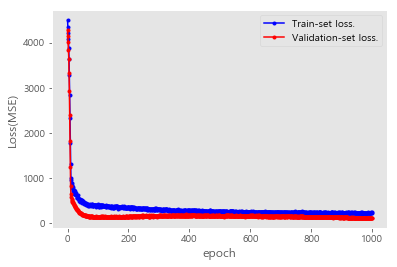

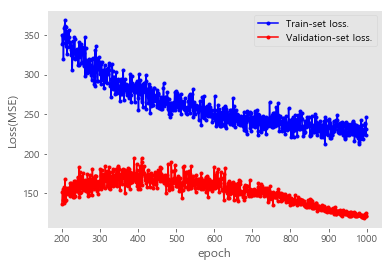

In [35]:
keras_mse = [] # 다른 모델들간의 비교를 위해 만들어둔것

model1, comp1 = kerasRegression(x_train, y_train1, x_test, y_test1)
keras_mse.append(model1[0])

658/658 [==============================] - 0s 14us/sample - loss: 98.5274 - mean_squared_error: 98.5274
loss (mean_squared_error) : 98.52743363307964


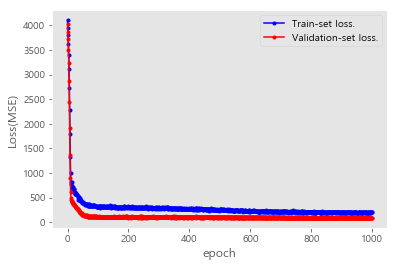

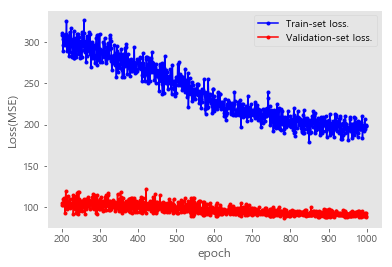

In [36]:
model2, comp2 = kerasRegression(x_train, y_train2, x_test, y_test2)
keras_mse.append(model2[0])

658/658 [==============================] - 0s 14us/sample - loss: 142.8587 - mean_squared_error: 142.8587
loss (mean_squared_error) : 142.85870472638442


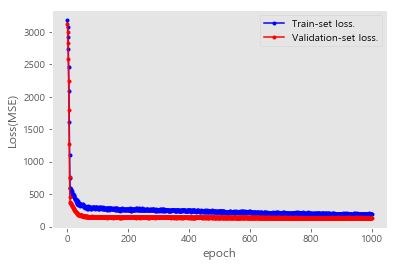

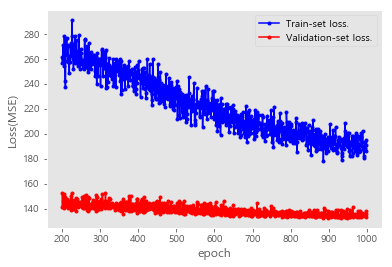

In [37]:
model3, comp3 = kerasRegression(x_train, y_train3, x_test, y_test3)
keras_mse.append(model3[0])

658/658 [==============================] - 0s 15us/sample - loss: 190.9153 - mean_squared_error: 190.9153
loss (mean_squared_error) : 190.9153101031179


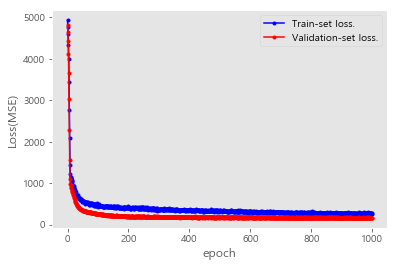

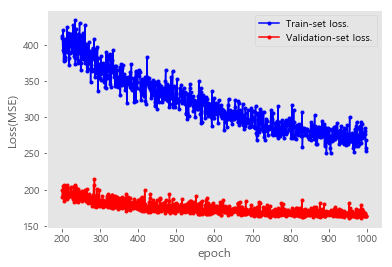

In [38]:
model4, comp4 = kerasRegression(x_train, y_train4, x_test, y_test4)
keras_mse.append(model4[0])

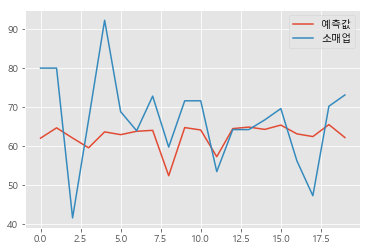

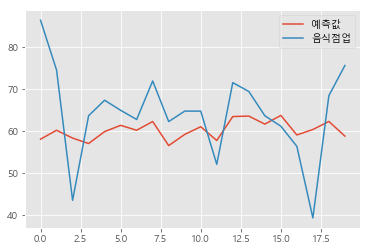

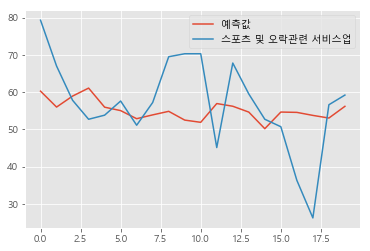

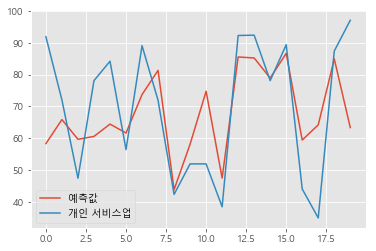

In [39]:
comp1.plot()
comp2.plot()
comp3.plot()
comp4.plot()

- 딥러닝이 특히 개인 서비스업 분야에서 성능이 뛰어났습니다.

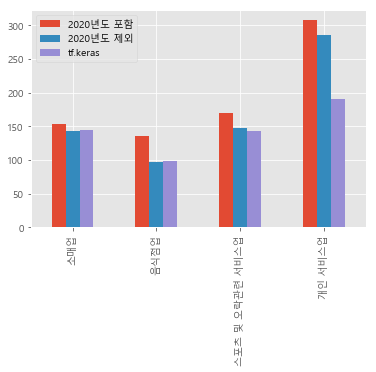

In [40]:
df_kmse = pd.DataFrame(keras_mse)
df_kmse = df_kmse.rename(columns={0:'tf.keras'}
                         ,index={0:'소매업',1:'음식점업', 2:'스포츠 및 오락관련 서비스업', 3:'개인 서비스업'})

all_comp = mse_comp.join(df_kmse)
all_comp.plot(kind='bar')

- 딥러닝 모델에 대해서도 2019년도 예측과 2020년도 예측을 비교해 보았습니다.

365/365 [==============================] - 0s 16us/sample - loss: 67.5558 - mean_squared_error: 67.5558
loss (mean_squared_error) : 67.55576995431561


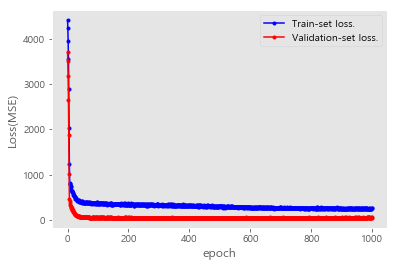

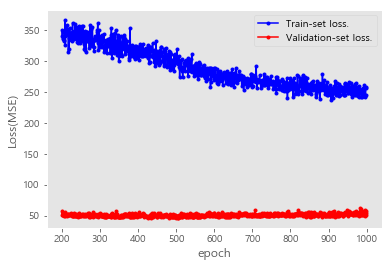

In [41]:
model1, comp2019 = kerasRegression(trainx, trainy1, testx1, testy1)

365/365 [==============================] - 0s 16us/sample - loss: 27.5797 - mean_squared_error: 27.5797
loss (mean_squared_error) : 27.579724047935173


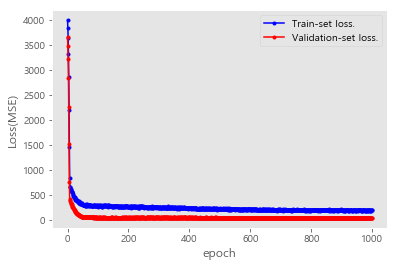

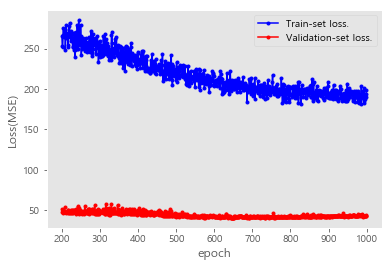

In [42]:
model2, comp20192 = kerasRegression(trainx, trainy2, testx1, testy2)

335/335 [==============================] - 0s 18us/sample - loss: 284.6712 - mean_squared_error: 284.6712
loss (mean_squared_error) : 284.67122217434553


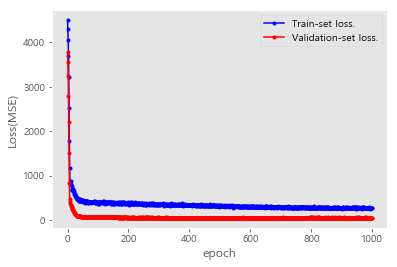

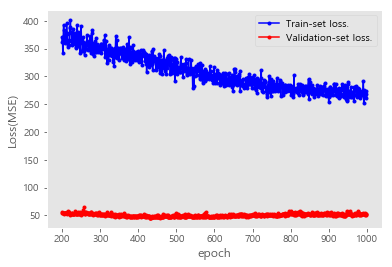

In [43]:
model3, comp2020 = kerasRegression(trainx, trainy1, testx2, testy3)

335/335 [==============================] - 0s 18us/sample - loss: 483.6352 - mean_squared_error: 483.6352
loss (mean_squared_error) : 483.6351570698752


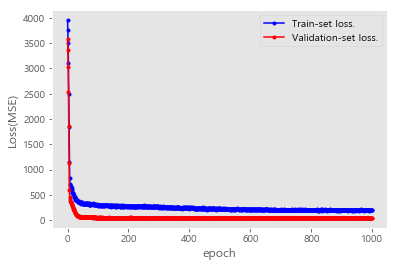

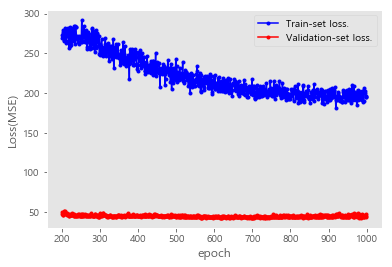

In [44]:
model4, comp20202 = kerasRegression(trainx, trainy2, testx2, testy4)

In [45]:
kmse19_list = [model1[0], model2[0]]
df_kmse19 = pd.DataFrame(kmse19_list)
df_kmse19 = df_kmse19.rename(columns={0:'19년도 keras mse'})

kmse20_list = [model3[0], model4[0]]
df_kmse20 = pd.DataFrame(kmse20_list)
df_kmse20 = df_kmse20.rename(columns={0:'20년도 keras  mse'})

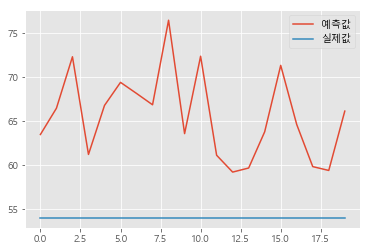

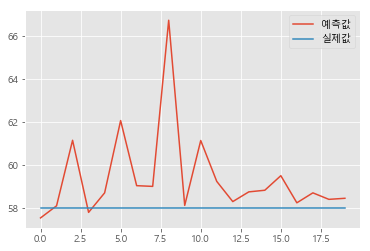

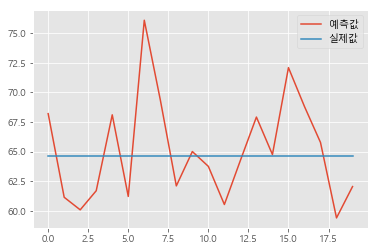

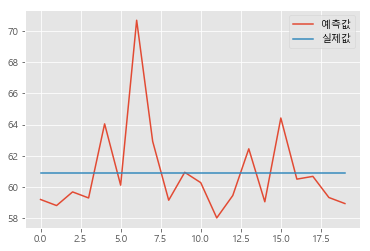

In [46]:
comp2019.plot()
comp20192.plot()
comp2020.plot()
comp20202.plot()

- 딥러닝 모델에서도 이전과 같이 2020년도 데이터의 mse값이 매우 크게 나오는 것을 볼 수 있습니다.

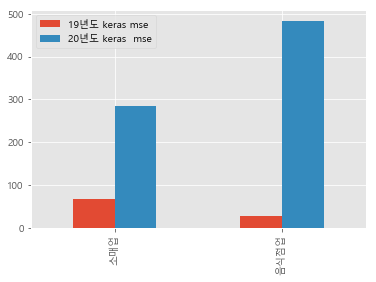

In [50]:
df_k1920 = df_kmse19.join(df_kmse20)
df_k1920 = df_k1920.rename(index={0:'소매업', 1:'음식점업'})

df_k1920.plot(kind='bar')

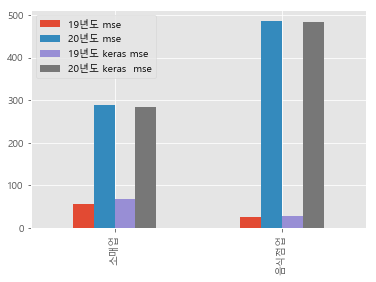

In [48]:
df_1920all = df_1920.join(df_k1920)
df_1920all = df_1920all.rename(index={0:'소매업',1:'음식점업'})

df_1920all
df_1920all.plot(kind='bar')

- 날씨가 업종마다의 BSI지수에 어느정도 영향을 주는것을 볼 수 있었으나,
- 날씨 이외에도 '코로나'같은 다른 강력한 요인도 큰 영향을 줌을 볼 수 있었습니다.